# Surface water quality data

In [1]:
library(dataRetrieval)

In [2]:
library(ggplot2)

In [3]:
library(gridExtra)

In [4]:
stream <- read.csv("stream.csv")
stream_stations <- stream[,c(1,5)]
stream_stations_USGS <- stream[grepl("USGS", stream$Monitoring),]
stream_stations_STORES <- stream[!grepl("USGS", stream$Monitoring),]

In [5]:
#USGS stream nitrate
stream_stations_USGS$Monitoring <- gsub("[a-zA-Z -]", "", stream_stations_USGS$Monitoring)
stream_ID <- stream_stations_USGS$Monitoring
Stream_ID_info <- readNWISsite(siteNumbers = stream_ID)
length(Stream_ID_info)
parameterCd <- c("00618","71851")
parameterCd <- c("00618")
startDate <- "1950-10-01"
endDate <- "2018-09-30"

dfwide <- readNWISqw(stream_ID, parameterCd, startDate, endDate)

[1] 42

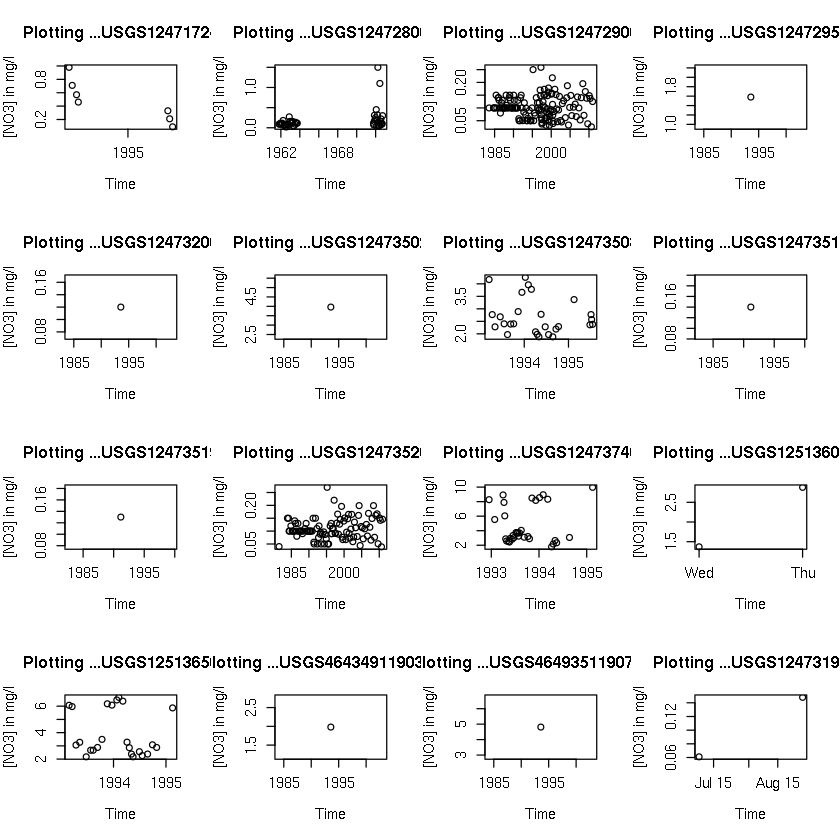

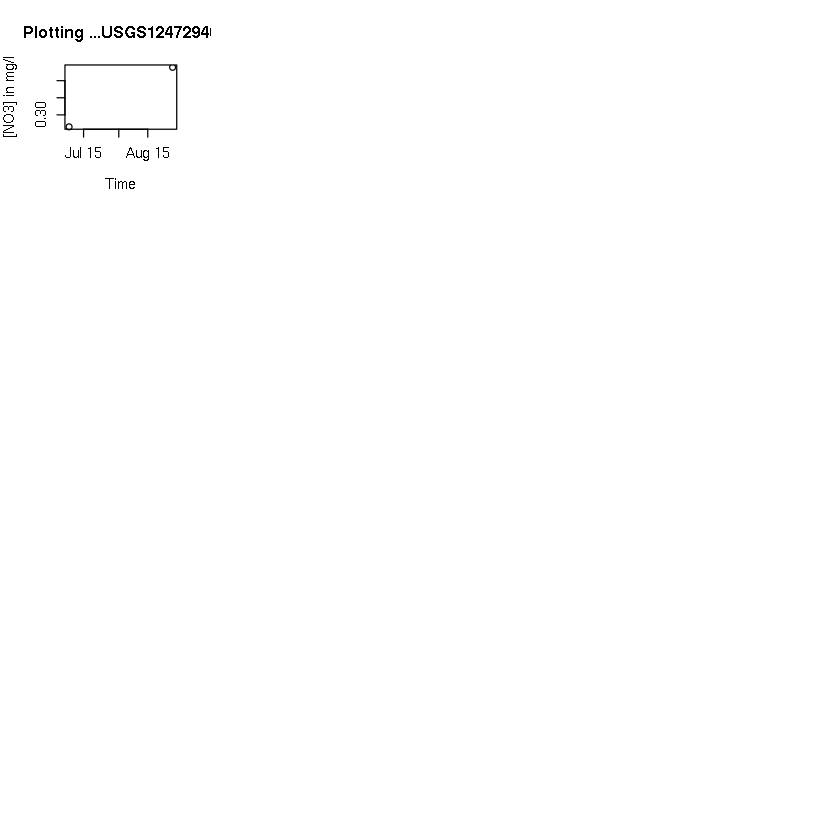

In [6]:
dat <- dfwide[,c("site_no","sample_dt", "result_va")]
par(mfrow=c(4,4))
for (i in 1:length(unique(dat$site_no))) {
  dat1 <- dat[dat$site_no == unique(dat$site_no)[i],]
  plot(dat1$sample_dt, dat1$result_va, main= paste0("Plotting ...USGS", unique(dat$site_no)[i]), 
       xlab="Time", ylab="[NO3] in mg/l" )
}

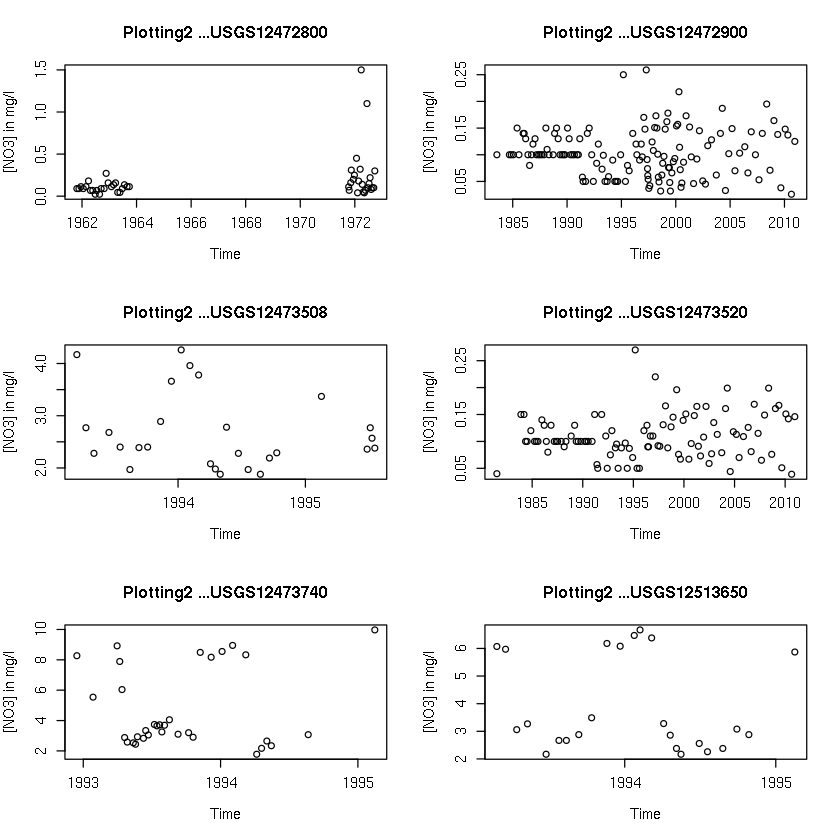

In [7]:
par(mfrow=c(3,2))
x <- c(2,3,7,10,11,13)
for (i in x) {
  dat1 <- dat[dat$site_no == unique(dat$site_no)[i],]
  plot(dat1$sample_dt, dat1$result_va, main= paste0("Plotting2 ...USGS", unique(dat$site_no)[i]), 
       xlab="Time", ylab="[NO3] in mg/l" )
}
#par(mfrow=c(1,1))
#counts <- sort( table(dat$site_no), decreasing = T)
#barplot(counts, main="Nitrate Sampling", xlab="Station")

# Groundwater data presentation

library(gridExtra)

In [8]:
transform_piper_data <- function(Mg, Ca, Cl,SO4, name=NULL){
  if(is.null(name)){
    name = rep(1:length(Mg),3)
  } else {
    name = rep(name,3)
  }
  y1 <- Mg * 0.86603
  x1 <- 100*(1-(Ca/100) - (Mg/200))
  y2 <- SO4 * 0.86603
  x2 <-120+(100*Cl/100 + 0.5 * 100*SO4/100)
  new_point <- function(x1, x2, y1, y2, grad=1.73206){
    b1 <- y1-(grad*x1)
    b2 <- y2-(-grad*x2)
    M <- matrix(c(grad, -grad, -1,-1), ncol=2)
    intercepts <- as.matrix(c(b1,b2))
    t_mat <- -solve(M) %*% intercepts
    data.frame(x=t_mat[1,1], y=t_mat[2,1])
  }
  np_list <- lapply(1:length(x1), function(i) new_point(x1[i], x2[i], y1[i], y2[i]))
  npoints <- do.call("rbind",np_list)
  data.frame(observation=name,x=c(x1, x2, npoints$x), y=c(y=y1, y2, npoints$y))
}

In [9]:
ggplot_piper <- function() {
  library(ggplot2)
  grid1p1 <<- data.frame(x1 = c(20,40,60,80), x2= c(10,20,30,40),y1 = c(0,0,0,0), y2 = c(17.3206,34.6412,51.9618, 69.2824))
  grid1p2 <<- data.frame(x1 = c(20,40,60,80), x2= c(60,70,80,90),y1 = c(0,0,0,0), y2 = c(69.2824, 51.9618,34.6412,17.3206))
  grid1p3 <<- data.frame(x1 = c(10,20,30,40), x2= c(90,80,70,60),y1 = c(17.3206,34.6412,51.9618, 69.2824), y2 = c(17.3206,34.6412,51.9618, 69.2824))
  grid2p1 <<- grid1p1
  grid2p1$x1 <- grid2p1$x1+120
  grid2p1$x2 <- grid2p1$x2+120
  grid2p2 <<- grid1p2
  grid2p2$x1 <- grid2p2$x1+120
  grid2p2$x2 <- grid2p2$x2+120
  grid2p3 <<- grid1p3
  grid2p3$x1 <- grid2p3$x1+120
  grid2p3$x2 <- grid2p3$x2+120
  grid3p1 <<- data.frame(x1=c(100,90, 80, 70),y1=c(34.6412, 51.9618, 69.2824, 86.603), x2=c(150, 140, 130, 120), y2=c(121.2442,138.5648,155.8854,173.2060))
  grid3p2 <<- data.frame(x1=c(70, 80, 90, 100),y1=c(121.2442,138.5648,155.8854,173.2060), x2=c(120, 130, 140, 150), y2=c(34.6412, 51.9618, 69.2824, 86.603))
  
  p <- ggplot() +
    ## left hand ternary plot
    geom_segment(aes(x=0,y=0, xend=100, yend=0)) +
    geom_segment(aes(x=0,y=0, xend=50, yend=86.603)) +
    geom_segment(aes(x=50,y=86.603, xend=100, yend=0)) +
    ## right hand ternary plot
    geom_segment(aes(x=120,y=0, xend=220, yend=0)) +
    geom_segment(aes(x=120,y=0, xend=170, yend=86.603)) +
    geom_segment(aes(x=170,y=86.603, xend=220, yend=0)) +
    ## Upper diamond
    geom_segment(aes(x=110,y=190.5266, xend=60, yend=103.9236)) +
    geom_segment(aes(x=110,y=190.5266, xend=160, yend=103.9236)) +
    geom_segment(aes(x=110,y=17.3206, xend=160, yend=103.9236)) +
    geom_segment(aes(x=110,y=17.3206, xend=60, yend=103.9236)) +
    ## Add grid lines to the plots
    geom_segment(aes(x=x1, y=y1, yend=y2, xend=x2), data=grid1p1, linetype = "dashed", size = 0.25, colour = "grey50") +
    geom_segment(aes(x=x1, y=y1, yend=y2, xend=x2), data=grid1p2, linetype = "dashed", size = 0.25, colour = "grey50") +
    geom_segment(aes(x=x1, y=y1, yend=y2, xend=x2), data=grid1p3, linetype = "dashed", size = 0.25, colour = "grey50") +
    geom_segment(aes(x=x1, y=y1, yend=y2, xend=x2), data=grid2p1, linetype = "dashed", size = 0.25, colour = "grey50") +
    geom_segment(aes(x=x1, y=y1, yend=y2, xend=x2), data=grid2p2, linetype = "dashed", size = 0.25, colour = "grey50") +
    geom_segment(aes(x=x1, y=y1, yend=y2, xend=x2), data=grid2p3, linetype = "dashed", size = 0.25, colour = "grey50") +
    geom_segment(aes(x=x1, y=y1, yend=y2, xend=x2), data=grid3p1, linetype = "dashed", size = 0.25, colour = "grey50") +
    geom_segment(aes(x=x1, y=y1, yend=y2, xend=x2), data=grid3p2, linetype = "dashed", size = 0.25, colour = "grey50") +
    ### Labels and grid values
    #geom_text(aes(50,-10, label="Ca^2"), parse=T, size=4) + # Commented out, as parse=TRUE can cause issues
    
    geom_text(aes(c(20,40,60,80),c(-5,-5,-5,-5), label=c(80, 60, 40, 20)), size=3) +
    geom_text(aes(c(35,25,15,5),grid1p2$y2, label=c(80, 60, 40, 20)), size=3) +
    geom_text(aes(c(95,85,75,65),grid1p3$y2, label=c(80, 60, 40, 20)), size=3) +
    # geom_text(aes(17,50, label="Mg^2"), parse=T, angle=60, size=4) +
    coord_equal(ratio=1)+  
    geom_text(aes(17,50, label="Mg^2"), angle=60, size=4, parse=TRUE) +  
    geom_text(aes(82.5,50, label="Na + K"), angle=-60, size=4) +
    geom_text(aes(50,-10, label="Ca^2"), size=4, parse=TRUE) +
    
    
    geom_text(aes(170,-10, label="Cl^-phantom()"), size=4, parse=TRUE) +
    geom_text(aes(205,50, label="SO^4"), angle=-60, size=4, parse=TRUE) +
    geom_text(aes(137.5,50, label="HCO^3"), angle=60, size=4, parse=TRUE) +
    geom_text(aes(72.5,150, label="SO^4~+~Cl^-phantom()"), angle=60, size=4, parse=TRUE) +
    geom_text(aes(147.5,150, label="Ca^2~+~Mg^2"), angle=-60, size=4, parse=TRUE) + 
    
    geom_text(aes(c(155,145,135,125),grid2p2$y2, label=c(20, 40, 60, 80)), size=3) +
    geom_text(aes(c(215,205,195,185),grid2p3$y2, label=c(20, 40, 60, 80)), size=3) +
    geom_text(aes(c(140,160,180,200),c(-5,-5,-5,-5), label=c(20, 40, 60, 80)), size=3) +
    geom_text(aes(grid3p1$x1-5,grid3p1$y1, label=c(80, 60, 40, 20)), size=3) +
    geom_text(aes(grid3p1$x2+5,grid3p1$y2, label=c(20, 40, 60, 80)), size=3) +
    geom_text(aes(grid3p2$x1-5,grid3p2$y1, label=c(20, 40, 60, 80)), size=3) +
    geom_text(aes(grid3p2$x2+5,grid3p2$y2, label=c(80, 60, 40, 20)), size=3) +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.border = element_blank(), axis.ticks = element_blank(),
          axis.text.x = element_blank(), axis.text.y = element_blank(),
          axis.title.x = element_blank(), axis.title.y = element_blank())
  return(p)
}

In [10]:
data2 <- read.csv("MajorIons_extracted4.csv")
data <- data2[,c(24:28)]

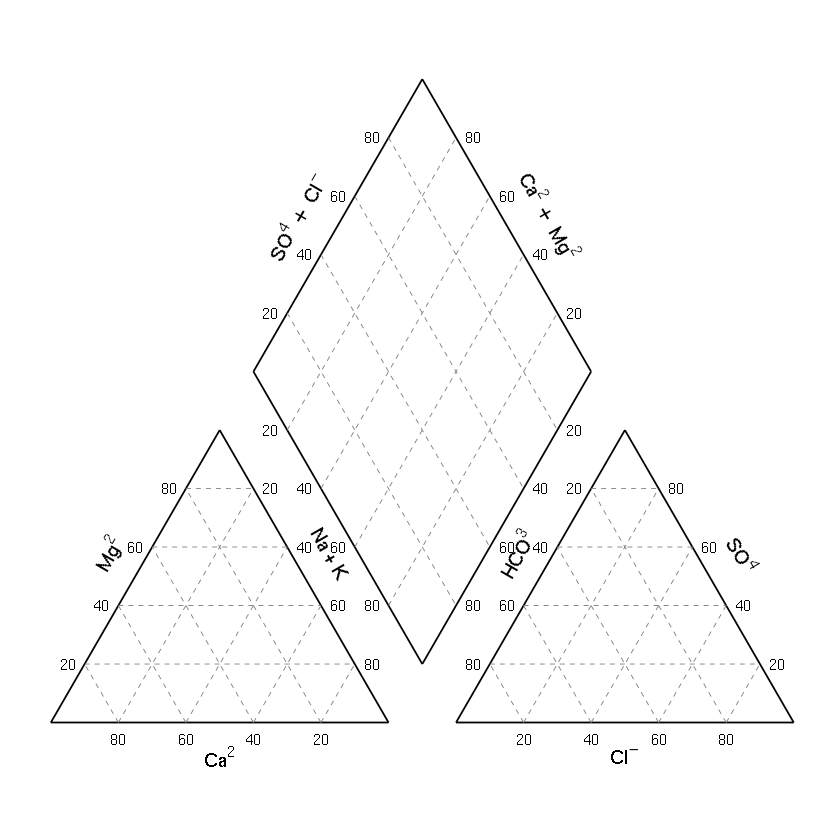

In [11]:
piper_data <- transform_piper_data(Ca=data$Ca, Mg = data$Mg, Cl=data$Cl, SO4= data$SO4, name=data$WaterType)
ggplot_piper()

![](Piper_Plot.jpg)

In [12]:
#<img src="Piper_Plot.jpg"/>

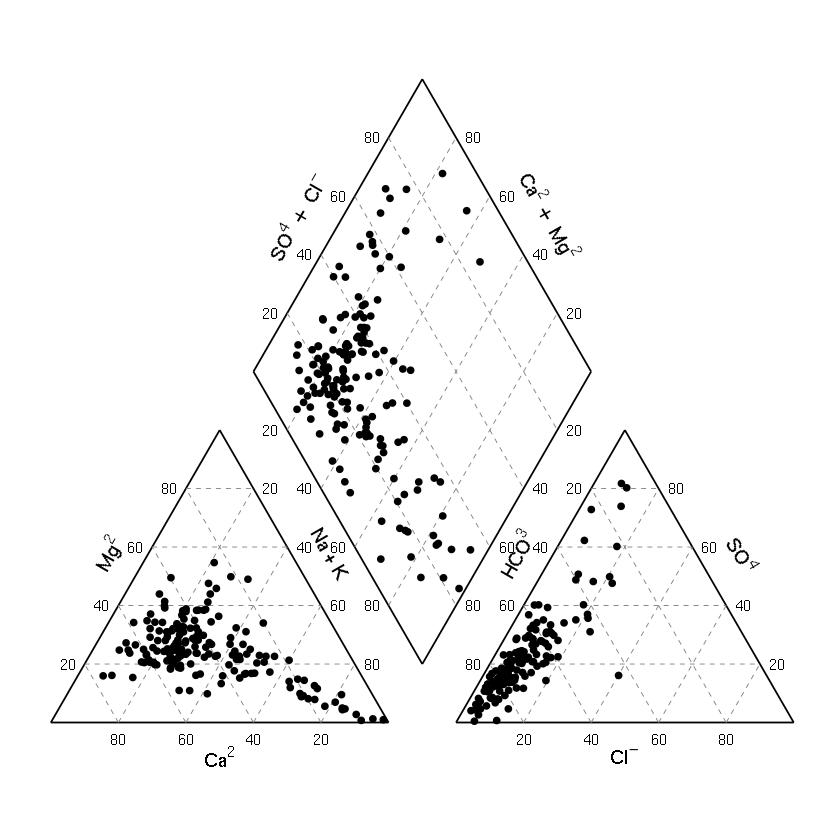

In [13]:
ggplot_piper() + geom_point(aes(x,y), data=piper_data)
# colouring the points can be done using the observation value;
# The size can be changed like..
#ggplot_piper() + geom_point(aes(x,y, colour=factor(observation)), size=4, data=piper_data)

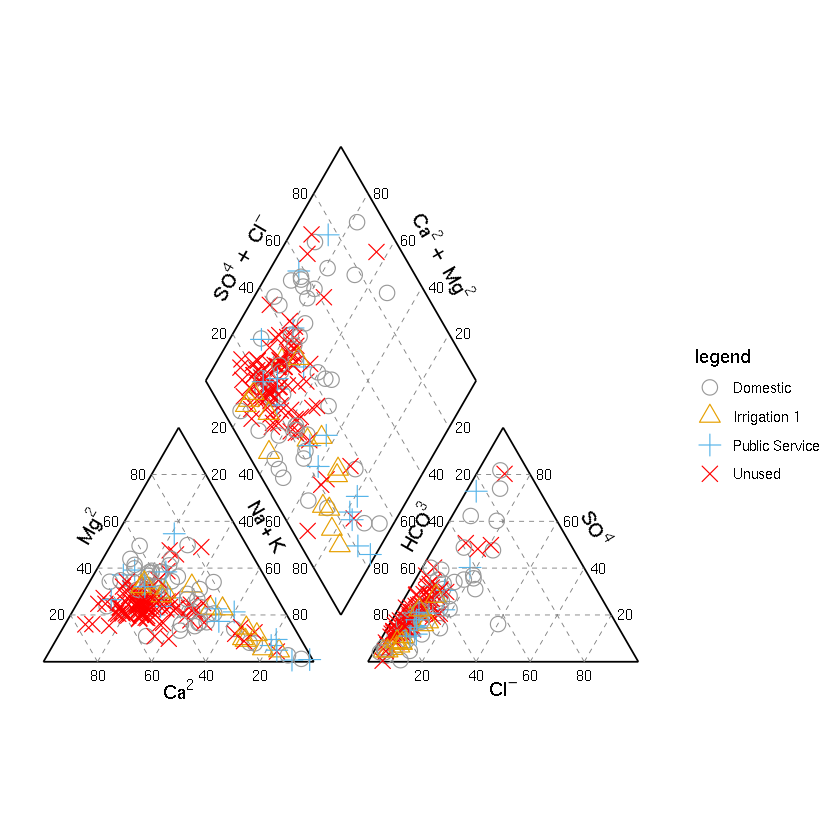

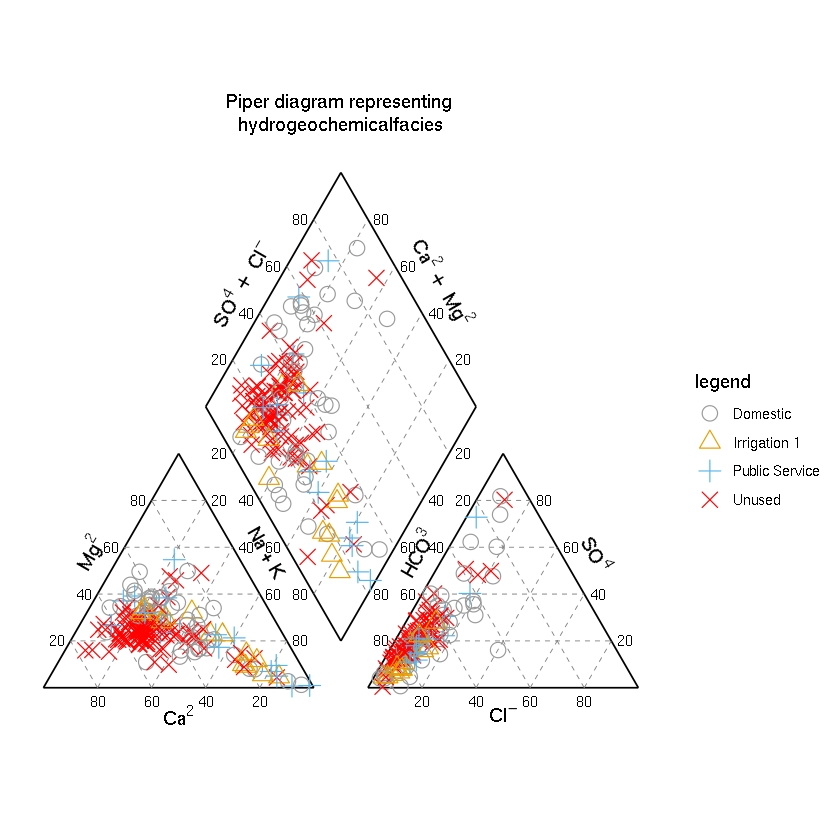

In [14]:
ggplot_piper() + geom_point(aes(x,y, colour=factor(observation), shape=factor(observation)), size=4, data=piper_data) + 
  scale_colour_manual(name="legend", values=c("#999999", "#E69F00", "#56B4E9", "red"), labels=c("Domestic", "Irrigation 1", "Public Service", "Unused")) +
  scale_shape_manual(name="legend", values=c(1,2,3,4), labels=c("Domestic", "Irrigation 1", "Public Service", "Unused"))
## with title at center alligned
ggplot_piper() + geom_point(aes(x,y, colour=factor(observation), shape=factor(observation)), size=4, data=piper_data) + 
  scale_colour_manual(name="legend", values=c("#999999", "#E69F00", "#56B4E9", "red"), labels=c("Domestic", "Irrigation 1", "Public Service", "Unused")) +
  scale_shape_manual(name="legend", values=c(1,2,3,4), labels=c("Domestic", "Irrigation 1", "Public Service", "Unused")) + 
  ggtitle("Piper diagram representing \nhydrogeochemicalfacies") + theme(plot.title = element_text(hjust = 0.5))


In [15]:
#head(data)
data2 <- read.csv("MajorIons_extracted4.csv")
data <- data2[,c(24:28)]

In [16]:
i <- 1
for (i in 1:4) {
  data <- data2[,c(24:28)]
  data1 <- data[which(data$WaterType == i),]
  
  if (i == 1) {
    data <- data1
    piper_data <- transform_piper_data(Ca=data$Ca, Mg = data$Mg, Cl=data$Cl, SO4= data$SO4, name=data$WaterType)
    Domestic <- ggplot_piper() + geom_point(aes(x,y, colour=factor(observation), shape=factor(observation)), size=4, data=piper_data) + 
      scale_colour_manual(name="Legend", values=c("#999999", "#E69F00", "#56B4E9", "red"), labels=c("Domestic", "Irrigation 1", "Public Service", "Unused")) +
      scale_shape_manual(name="Legend", values=c(1,2,3,4), labels=c("Domestic", "Irrigation", "Public Service", "Unused"))
    
  } else if (i == 2) {
    data <- data1
    piper_data <- transform_piper_data(Ca=data$Ca, Mg = data$Mg, Cl=data$Cl, SO4= data$SO4, name=data$WaterType)
    Irrigation <- ggplot_piper() + geom_point(aes(x,y, colour=factor(observation), shape=factor(observation)), size=4, data=piper_data) + 
      scale_colour_manual(name="Legend", values=c("#E69F00", "#E69F00", "#56B4E9", "red"), labels=c("Irrigation", "Irrigation", "Public Service", "Unused")) +
      scale_shape_manual(name="Legend", values=c(2,2,3,4), labels=c("Irrigation", "Irrigation", "Public Service", "Unused"))
  } else if (i == 3) {
    data <- data1
    piper_data <- transform_piper_data(Ca=data$Ca, Mg = data$Mg, Cl=data$Cl, SO4= data$SO4, name=data$WaterType)
    Public_Service <- ggplot_piper() + geom_point(aes(x,y, colour=factor(observation), shape=factor(observation)), size=4, data=piper_data) + 
      scale_colour_manual(name="Legend", values=c("#56B4E9", "#56B4E9", "#56B4E9", "red"), labels=c("Public Service", "Irrigation", "Public Service", "Unused")) +
      scale_shape_manual(name="Legend", values=c(3,3,3,4), labels=c("Public Service", "Irrigation", "Public Service", "Unused"))
  } else {
    data <- data1
    piper_data <- transform_piper_data(Ca=data$Ca, Mg = data$Mg, Cl=data$Cl, SO4= data$SO4, name=data$WaterType)
    Unused <- ggplot_piper() + geom_point(aes(x,y, colour=factor(observation), shape=factor(observation)), size=4, data=piper_data) + 
      scale_colour_manual(name="Legend", values=c("red", "#E69F00", "#56B4E9", "red"), labels=c("Unused", "Irrigation", "Public Service", "Unused")) +
      scale_shape_manual(name="Legend", values=c(4,4,4,4), labels=c("Unused", "Irrigation", "Public Service", "Unused"))
  }
}

In [17]:
#grid.arrange(Domestic,Irrigation,Public_Service,Unused)

In [18]:
par(mfrow = c(2,2))

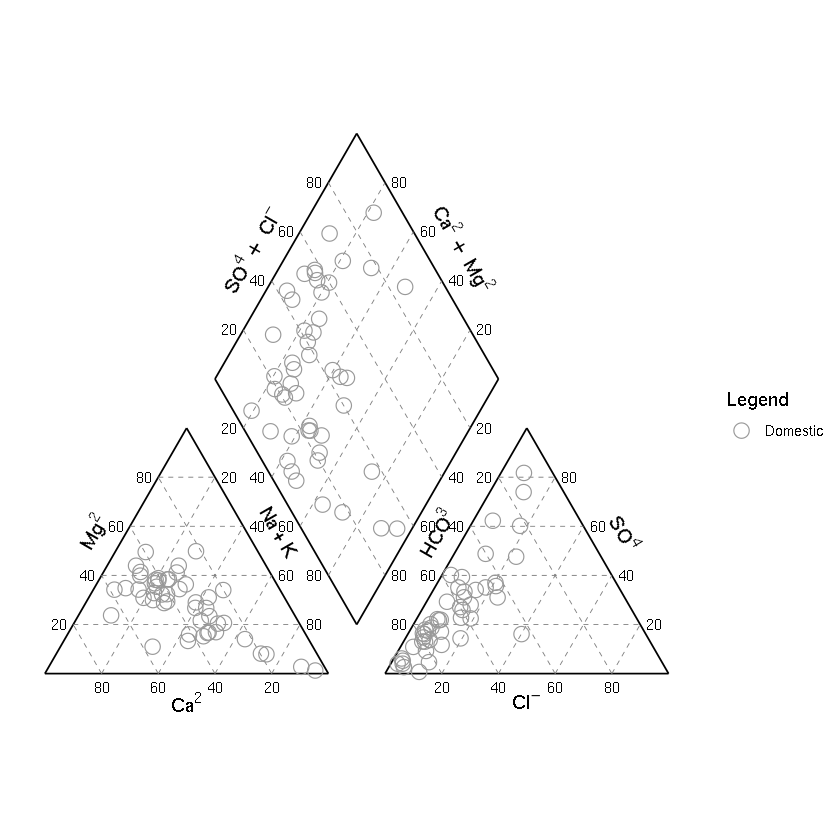

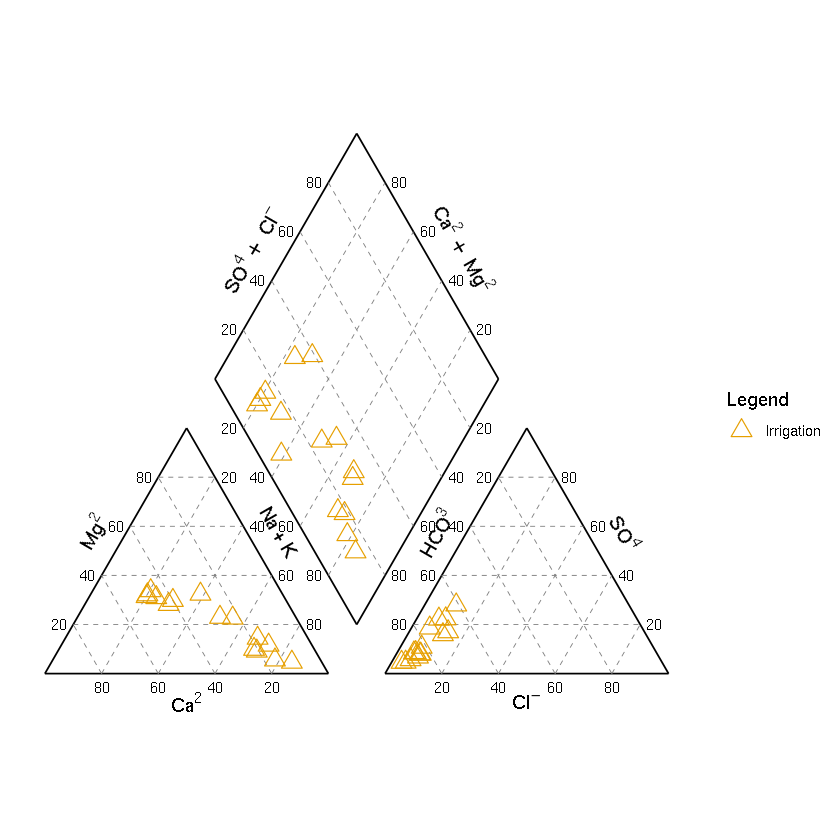

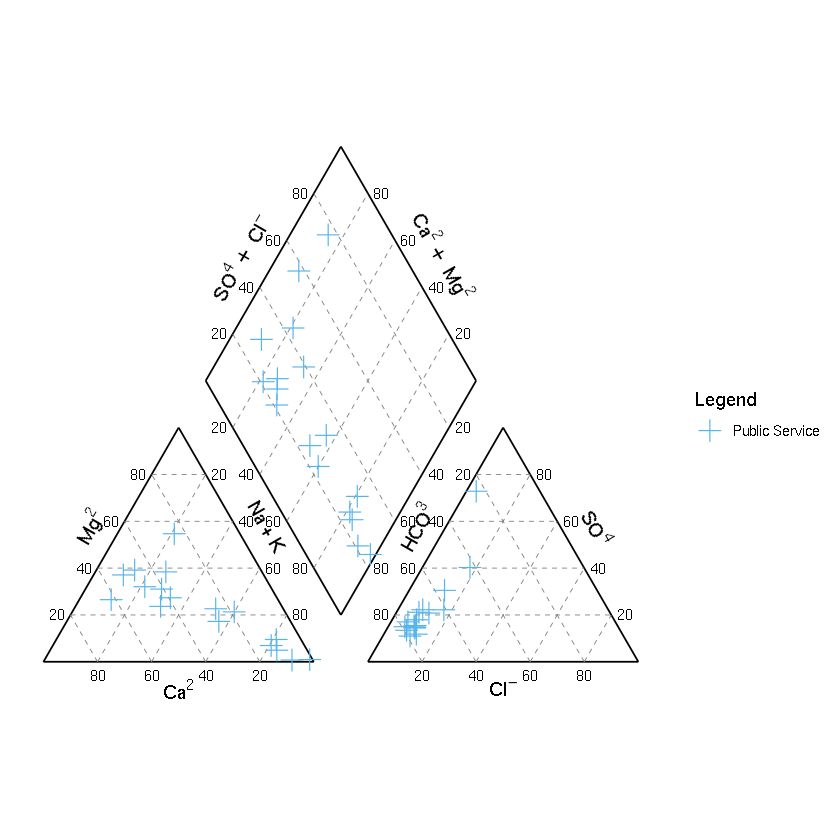

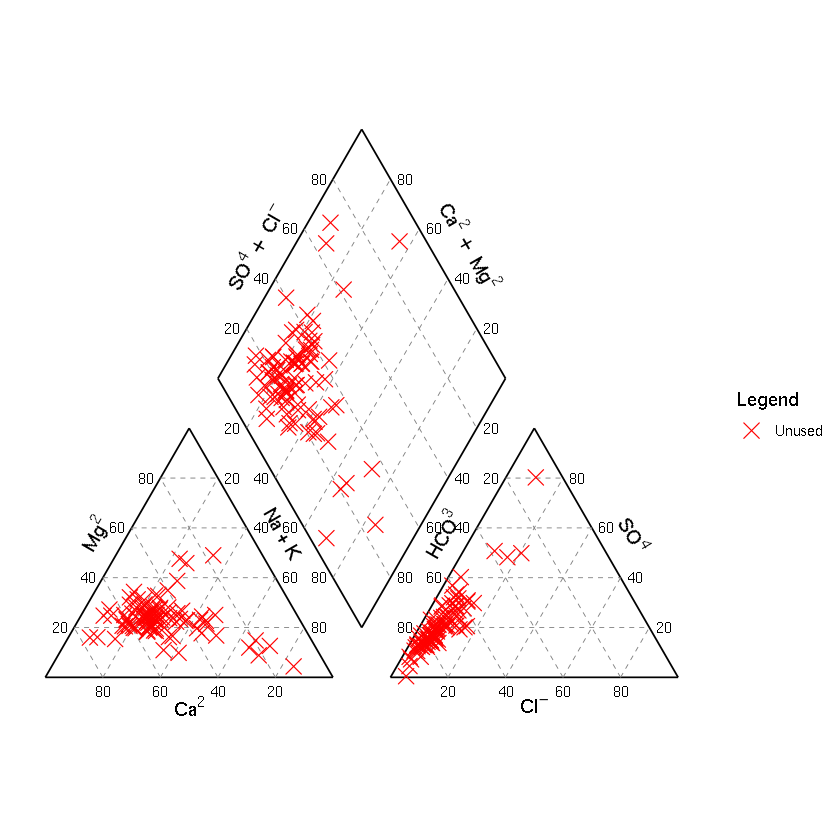

In [19]:
Domestic;Irrigation;Public_Service;Unused

# Close to 85,000 groundwater quality with nitrate samples are extracted. 

![](Wells_USGS1.jpg)

![](LULC_USGS1.jpg)

![](All_Wells.jpg)

In [20]:
dat <- read.csv("Nitrate.csv", header = TRUE)

In [21]:
#dim(dat)

In [22]:
dat1 <- dat[,c(3,5,7,79)] # concentration in microgram per limter (ug/l)
# Simple Bar Plot 
counts <- table(dat1$WellName)
sample_id <- unique(as.character(dat1$WellName))
dat1$DateTime <- as.Date(dat1$DateTime)

In [23]:
#getwd()

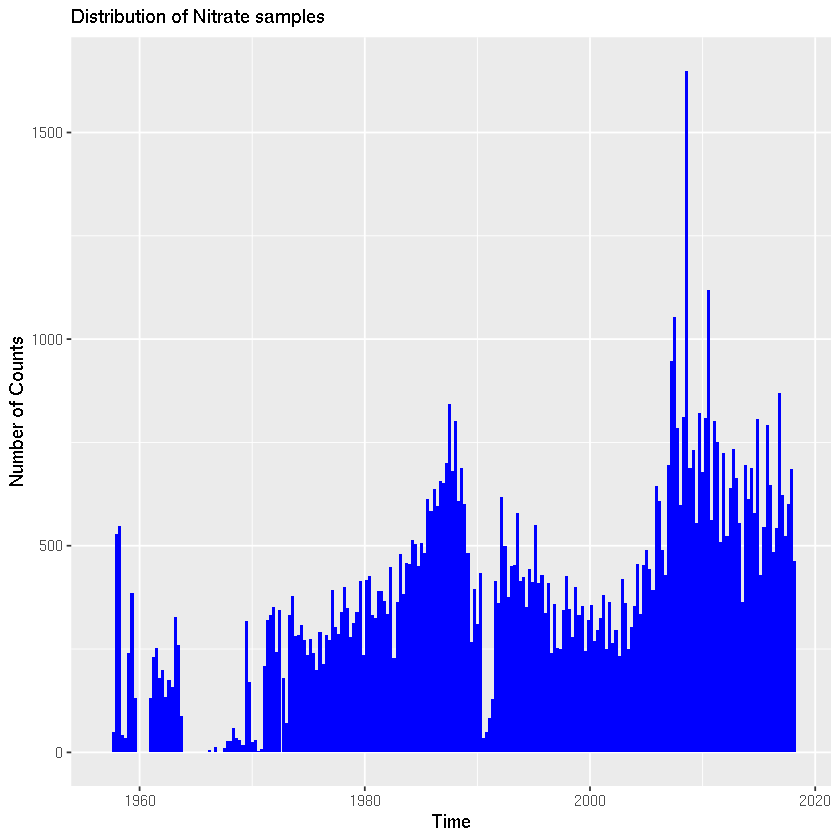

In [24]:
ggplot(dat1, aes(x=as.Date(DateTime), fill=Concentration)) + 
  geom_histogram(fill ="blue", binwidth = 100)+
  labs(title = "Distribution of Nitrate samples", x="Time", y = "Number of Counts")


In [25]:
i <- 1
j <- 1
par(mfrow = c(2, 2))  # Set up a 2 x 2 plotting space
a <- list()
for (i in 1:length(sample_id)) {
  dat2 <- dat1[which(dat1$WellName==sample_id[i]),]
  if (length(dat2$Concentration) > 100){
    autotitle <- paste("Nitrate Concentration at station",sample_id[i])
    a[[j]] <- ggplot(data=dat2, aes(x=DateTime, y=Concentration/1000)) + 
      geom_point() +
      scale_y_continuous(limits=c(0,max(dat2$Concentration/1000))) + 
      # geom_line() + 
      labs(title= autotitle,x="Time", y = "NO3 in milligram/liter")
    #print(a)
    j <- j+1
  }
}

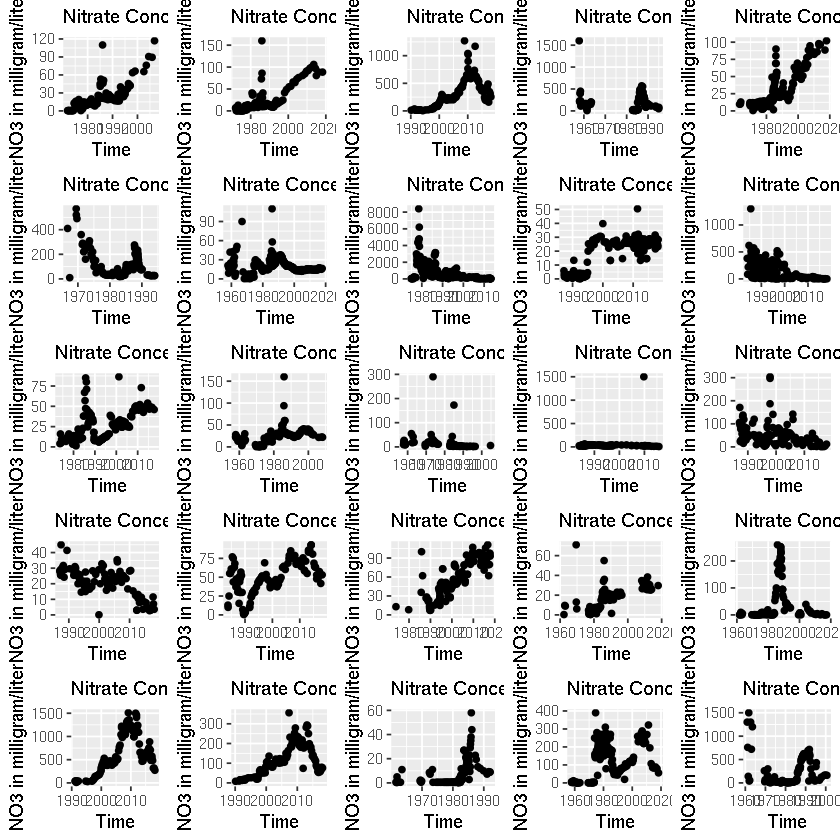

In [26]:
b <- a[1:25]
do.call(grid.arrange,b)